In [ ]:
import os
import matplotlib.pyplot as plt
import time
# from PIL import Image
import numpy as np
# import math
import warnings
import torch
import cv2
# from torchvision import transforms

# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 1. 데이터 가져오기

In [ ]:
# MAIN_PATH = os.getcwd()
MAIN_PATH = 'your_project_path'

In [ ]:
# image_list: Test 이미지 파일명 리스트 (100개)
data_path = os.path.join(MAIN_PATH, 'celebrity_dataset') # RealTimeFaceRecognition 폴더 아래 'celebrity_dataset' 폴더 내에 존재
image_list = [file for file in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, file))]
image_list.sort()

# 각 이미지의 전체 경로
image_path_list = list(map(lambda x: os.path.join(data_path, x),image_list))
test_dataset = image_path_list

# image_list_label
name = ['박나래', '아이유', '이영지', '제니', '차은우']
image_list_label = []
for i in name:
  for j in range(20):
    image_list_label.append(i)

# 기준 얼굴 데이터
standard_list = os.listdir(data_path+'/기준얼굴')
standard_name = []
for standard_img in standard_list:
  standard_name.append(standard_img[:-4])

# standard 이미지의 전체 경로
standard_path_list = list(map(lambda x: os.path.join(data_path+'/기준얼굴', x),standard_list))

In [ ]:
print(len(test_dataset), len(standard_list))

100 5


# 2. Face Detection (RetinaFace)

## 경로 추가하기

In [ ]:
import sys
original_path = sys.path.copy()

retina_path = MAIN_PATH
sys.path.append(f'{retina_path}/Pytorch_Retinaface')


## 방법1 라이브러리로 한번에 모델 로드하고 Retinaface 결과와 alignment 얻기

In [ ]:
from detect_faces import extract

img_path = MAIN_PATH + "/celebrity_dataset/아이유17.jpg"

trained_model = MAIN_PATH + '/Pytorch_Retinaface/weights/Resnet50_Final.pth'
network="resnet50"
align=True

faces = extract(
    trained_model = trained_model,
    img_path = img_path,
    network=network,
    align=align)

cpu


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 220MB/s]


Loading pretrained model from /content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
net forward time: 0.3495
misc time: 0.0325


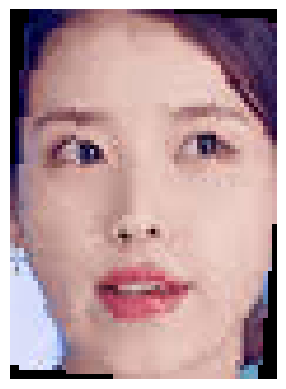

In [ ]:
# 시각화
for face in faces:
    plt.imshow(face)
    plt.axis('off')
    plt.show()

## 방법2 모델 미리 로드하고 RetinaFace 거쳐 alignment까지 얻기


In [ ]:
from detect_faces import Face_Dectector, save_img, crop_alignment, handle_korean_file_name
from models.retinaface import RetinaFace


trained_model = MAIN_PATH + '/Pytorch_Retinaface/weights/Resnet50_Final.pth'
img_path = MAIN_PATH + "/celebrity_dataset/차은우15.jpg"
network = "resnet50"
align=True

img_array = handle_korean_file_name(img_path) # 한글 파일 이름 처리

detector = Face_Dectector(
    trained_model=trained_model,
    network=network)

warming_up_img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
dets = detector.detect(warming_up_img)

cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.1MB/s]


Loading pretrained model from /content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
net forward time: 9.1801
misc time: 0.0172


In [ ]:
dets = detector.detect(img_array)

net forward time: 2.6305
misc time: 0.0314


In [ ]:
# 이미지 위에 bounding box와 랜드마크 표시하기
detected_img = img_array.copy()
detected_img = detector.draw_info(detected_img, dets=dets)

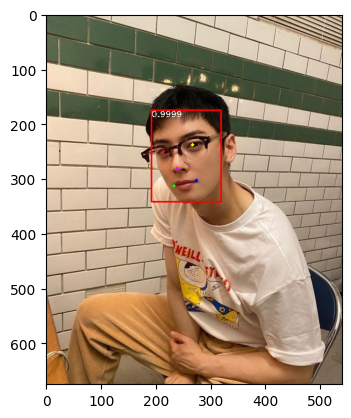

In [ ]:
# 수정된 이미지를 화면에 표시
# 시각화 1
plt.imshow(detected_img[:, :, ::-1]) # RGB 색상 변환

# 시각화 2
# cv2.imshow("image", detected_img)
# cv2.waitKey(0)

# 시각화 3
# from google.colab.patches import cv2_imshow
# cv2_imshow(detected_img)

In [ ]:
# 저장 경로에 이미지 저장하기
save_img(detected_img, "detected", save_path=MAIN_PATH)

save done


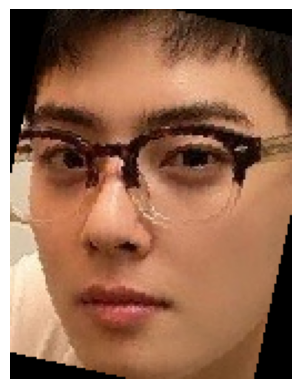

In [ ]:
# crop & alignment
faces = []
for b in dets:
    faces.append(crop_alignment(img_array, b))

# 시각화
for face in faces:
    plt.imshow(face)
    plt.axis('off')
    plt.show()

# 3. Face Recognition (ElasticFace)

In [ ]:
from numpy import dot
from numpy.linalg import norm

# 유사도 정의 함수
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

# 유클리드 거리
def euclidean(A, B):
  temp = A - B
  dist = np.sqrt(np.dot(temp.T, temp))
  return dist

## 의존성(Dependencies)

In [ ]:
!pip install -r /content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/RealTimeFaceRecognition/ElasticFace/requirement.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.2 MB/s eta 0:00:00
  Created wheel for menpo: filename=menpo-0.11.0-py3-none-any.whl size=1611831 sha256=14e83e5824d6b8fec20bd5d36e927896f3379acc06f06d40531fa7e315307523
  Stored in directory: /root/.cache/pip/wheels/1d/ea/95/42dae04c4e6a7fa66e171dc5b058a2305d598199423fd55110
Successfully built menpo
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


## Import packages

In [ ]:
import sys
MAIN_PATH = '/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble'
sys.path.append(f'{MAIN_PATH}/ElasticFace')
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/Pytorch_Retinaface', '/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/ElasticFace']


In [ ]:
import os
import sys
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import cv2

# 경고 메시지 무시
warnings.filterwarnings("ignore")

## Configure

In [ ]:
batch_size = 10
nfolds = 10
data_dir = "data_dir"
image_size = (112, 112)

ver_name = 'my_dataset'

In [ ]:
from config.config import config as cfg

from backbones.iresnet import iresnet100, iresnet50

gpu_id = 0
output_folder = "/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/RealTimeFaceRecognition/ElasticFace/output/R100_ElasticArcFace"
weights=os.listdir(output_folder)
print(weights)

for w in weights:
    if "backbone" in w:
        print(w)
        print(cfg.network)
        if cfg.network == "iresnet100":
            backbone = iresnet100(num_features=cfg.embedding_size).to(f"cuda:{gpu_id}")
        elif cfg.network == "iresnet50":
            backbone = iresnet50(num_classes=cfg.embedding_size).to(f"cuda:{gpu_id}")
        backbone.load_state_dict(torch.load(os.path.join(output_folder,w)))
        model = torch.nn.DataParallel(backbone, device_ids=[gpu_id])

model.eval()

## 이미지 전처리

In [ ]:
# 이미지를 입력 받아서 feature를 반환하는 코드

from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime

def my_transforms(array, image_size):
    transform = transforms.Compose([
        transforms.CenterCrop(image_size),  # 이미지 크기를 조정하되, 원본 비율을 유지
        transforms.ToTensor(),          # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
    ])

    img = Image.fromarray(array)
    img.thumbnail(image_size)
    img_tensor = transform(img)
    print(img_tensor.shape)


    return img_tensor

def inference(array):
  image_size = (112, 112)  # 목표 이미지 크기
  # img_path = "/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/myface/myface4.jpg"  # 이미지 파일 경로
  img_tensor = my_transforms(array, image_size)
  img_tensor = img_tensor.to('cuda')

  print(img_tensor.shape)
  img_tensor = torch.unsqueeze(img_tensor, dim=0)
  print(img_tensor.shape)

  time0 = datetime.datetime.now()

  net_out: torch.Tensor = model(img_tensor)
  camera_embeddings = net_out.detach().cpu().numpy()

  time_now = datetime.datetime.now()

  diff = time_now - time0
  print(diff)

  return camera_embeddings

# 4. 결과 확인

- image_path_list, image_list_label
- standard_path_list, standard_name


In [ ]:
from detect_faces import Face_Dectector, save_img, crop_alignment, handle_korean_file_name
from models.retinaface import RetinaFace


trained_model = MAIN_PATH + '/Pytorch_Retinaface/weights/Resnet50_Final.pth'
img_path = MAIN_PATH + "/celebrity_dataset/차은우16.jpg"
network = "resnet50"
align=True

img_array = handle_korean_file_name(img_path) # 한글 파일 이름 처리

detector = Face_Dectector(
    trained_model=trained_model,
    network=network)

warming_up_img = np.random.randint(0, 255, size=(112, 112, 3), dtype=np.uint8)
dets = detector.detect(warming_up_img)

faces = []
for b in dets:
    faces.append(crop_alignment(img_array, b, align=align))

cuda
Loading pretrained model from /content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
net forward time: 0.0097
misc time: 0.0044


cuda
Loading pretrained model from /content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/Pytorch_Retinaface/weights/Resnet50_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:456
Finished loading model!
net forward time: 0.0118
misc time: 0.0407
torch.Size([3, 112, 112])
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
0:00:00.254206
/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/celebrity_dataset/기준얼굴/차은우.jpg


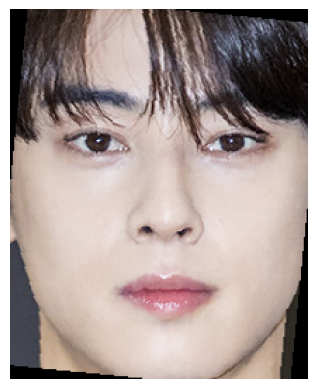

net forward time: 2.7384
misc time: 0.0459
torch.Size([3, 112, 112])
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
0:00:00.019828
/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/celebrity_dataset/기준얼굴/박나래.jpg


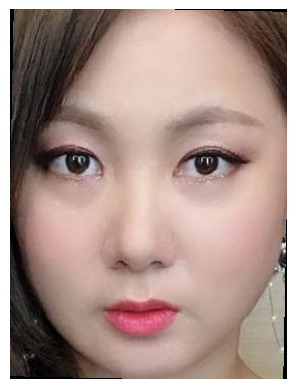

net forward time: 2.6076
misc time: 0.0214
torch.Size([3, 112, 112])
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
0:00:00.018165
/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/celebrity_dataset/기준얼굴/아이유.jpg


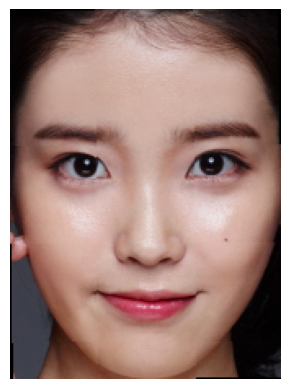

net forward time: 2.8468
misc time: 0.0741
torch.Size([3, 112, 112])
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
0:00:00.023721
/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/celebrity_dataset/기준얼굴/이영지.jpg


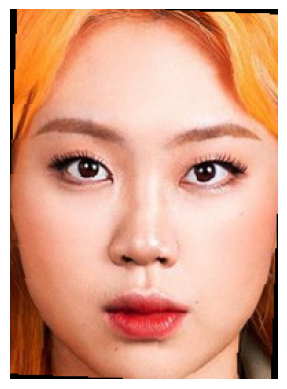

net forward time: 2.8443
misc time: 0.0543
torch.Size([3, 112, 112])
torch.Size([3, 112, 112])
torch.Size([1, 3, 112, 112])
0:00:00.017959
/content/drive/MyDrive/졸업프로젝트/2023-Marble-ML/Marble/celebrity_dataset/기준얼굴/제니.jpg


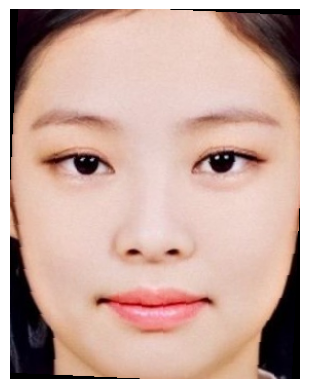

In [ ]:
#기준 얼굴 feature vector 생성
standard_dic = []

from detect_faces import Face_Dectector, save_img, crop_alignment
from models.retinaface import RetinaFace

trained_model = MAIN_PATH + '/Pytorch_Retinaface/weights/Resnet50_Final.pth'
img_path = MAIN_PATH + "/celebrity_dataset/차은우12.jpg"
network_detect="resnet50"
align=True

weight_path = MAIN_PATH + '/Pytorch_ArcFace/weights/backbone.pth'
network_recog = 'r50'

detector = Face_Dectector(
    trained_model=trained_model,
    network=network)


for standard_path in standard_path_list:

  img_array = handle_korean_file_name(standard_path) # 한글 파일 이름 처리
  dets = detector.detect(img_array)

  faces = []
  for b in dets:
      faces.append(crop_alignment(img_array, b, align=align))

  feat = inference(faces[0])
  print(standard_path)
  standard_dic.append(feat)

  plt.axis('off')
  plt.imshow(faces[0])
  plt.show()

In [ ]:
len(standard_dic), len(standard_name)

(5, 5)

In [ ]:
#label
standard_name

['차은우', '박나래', '아이유', '이영지', '제니']

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm
import math
#유사도 정의 함수
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
image_path_list

In [ ]:
#모든 파일 feature vector 생성
test_file = []

for image_path in image_path_list:

  img_array = handle_korean_file_name(image_path) # 한글 파일 이름 처리
  dets = detector.detect(img_array)

  faces = []
  for b in dets:
      faces.append(crop_alignment(img_array, b, align=align))

  plt.axis('off')
  plt.imshow(faces[0])
  plt.show()


  feat = inference(faces[0])

  print(image_path)
  test_file.append(feat)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(test_file[0]), len(test_file)

(1, 100)

In [ ]:
np.array(test_file[0]).reshape(-1,1).shape

(512, 1)

In [ ]:
np.array(standard_dic[0]).shape

(1, 512)

In [ ]:
test_similarity = [0.3, 0.5, 0.2, 0.8, 0.6, 0.9]
test_similarity

test_similarity.index(max(test_similarity))

5

In [ ]:
#cosine similarity
predict_label = []
similarity_score = []
for i in range(len(test_file)):
  test_similarity = []
  #각 기준파일과의 cosine similarity 계산 => 유사도가 가장 높은 이미지가 0.7 이상이면 label로 사용
  for j in range(len(standard_dic)):
    sim = cos_sim(np.array(test_file[i]), np.array(standard_dic[j]).reshape(-1,1))
    test_similarity.append(sim)

  test_similarity = np.array(test_similarity)
  max_value = np.max(test_similarity)
  similarity_score.append(max_value)

  if max_value > 0.3:
      index = np.argmax(test_similarity)
      max_name = standard_name[index]
  else:
      max_name = 'Unknown'

  # index = np.argmax(test_similarity)
  # max_name = standard_name[index]

  predict_label.append(max_name)

In [ ]:
for i,j,s in zip(image_list_label, predict_label, similarity_score):
  print(i, j, s)

박나래 박나래 0.5701534
박나래 박나래 0.43740922
박나래 박나래 0.30156803
박나래 박나래 0.6593991
박나래 Unknown 0.101376064
박나래 Unknown 0.1638722
박나래 박나래 0.44230947
박나래 박나래 0.64364547
박나래 박나래 0.46810946
박나래 박나래 0.6329526
박나래 Unknown 0.04272635
박나래 박나래 0.49687582
박나래 Unknown 0.25888675
박나래 박나래 0.52151865
박나래 Unknown 0.12668572
박나래 박나래 0.5994209
박나래 박나래 0.67445475
박나래 박나래 0.59592676
박나래 박나래 0.562999
박나래 Unknown 0.22566934
아이유 아이유 0.55219793
아이유 Unknown 0.26155818
아이유 아이유 0.34544086
아이유 Unknown 0.13764885
아이유 아이유 0.31192416
아이유 아이유 0.60172063
아이유 아이유 0.6612207
아이유 아이유 0.5450875
아이유 아이유 0.34578508
아이유 아이유 0.41517487
아이유 아이유 0.6090573
아이유 Unknown 0.10793698
아이유 Unknown 0.08916422
아이유 아이유 0.35688955
아이유 Unknown 0.2246529
아이유 아이유 0.5626585
아이유 Unknown 0.18035018
아이유 아이유 0.51440233
아이유 아이유 0.46696386
아이유 아이유 0.55407125
이영지 이영지 0.3564964
이영지 Unknown 0.24315041
이영지 Unknown 0.19385348
이영지 Unknown 0.18469079
이영지 이영지 0.

## 구분하지 못하는 얼굴을 살펴보자

In [ ]:
import unicodedata
num = 0
for i in range(100):
  #분리된 자음 모음 결합하는 코드
  label_predict = unicodedata.normalize('NFC',predict_label[i])
  label_actual = unicodedata.normalize('NFC',image_list_label[i])
  if label_predict == label_actual:
     num+=1
  else:
    print(f'\n index: {i} true:{image_list_label[i]} predict:{predict_label[i]}')
    img = cv2.imread(test_dataset[i])
    plt.imshow(img[:,:,::-1])
    plt.show()

print("Accuracy: ", num/100)

Output hidden; open in https://colab.research.google.com to view.